<a href="https://colab.research.google.com/github/qxisa/CatMood/blob/main/CatMoodelGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow torch torchvision

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) #the output here in this instance is going to be cuda due for using T4 GPU in this runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
Using device: cuda


In [2]:

from roboflow import Roboflow
rf = Roboflow(api_key="dvTvpb0jPoGOmO9yVqys")
project = rf.workspace("catmood-gvwb5").project("cat-emotions-iup1p")
version = project.version(1)
dataset = version.download("folder")  # downloads to /content/cat-emotions-iup1p-1


train_path = dataset.location + "/train"
valid_path = dataset.location + "/valid"


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cat-Emotions-1 in folder:: 100%|██████████| 1638/1638 [00:00<00:00, 4873.40it/s]


In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  #this is the only form of transformation that will be applied due that I've done randomized transformations already in the dataset on roboflow
    transforms.ToTensor(),
])

#loading the dataset from roboflow to the training paramters
train_dataset = ImageFolder(root=train_path, transform=transform)
valid_dataset = ImageFolder(root=valid_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)


In [4]:
#defining the model while using resnet18
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True) #not reinventing the wheel :)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device) #as defined above in the very first cell it's expected to be cuda or gpu pretty much, in case of running the code locally it'll be just cpu

#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


In [5]:

# Training loop
num_epochs = 20 #by far the best results

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {accuracy:.2f}%")


Epoch 1/20, Loss: 0.9848, Validation Accuracy: 66.00%
Epoch 2/20, Loss: 0.1557, Validation Accuracy: 69.00%
Epoch 3/20, Loss: 0.0590, Validation Accuracy: 69.00%
Epoch 4/20, Loss: 0.0254, Validation Accuracy: 71.00%
Epoch 5/20, Loss: 0.0191, Validation Accuracy: 67.00%
Epoch 6/20, Loss: 0.0283, Validation Accuracy: 65.00%
Epoch 7/20, Loss: 0.0194, Validation Accuracy: 69.00%
Epoch 8/20, Loss: 0.0160, Validation Accuracy: 67.00%
Epoch 9/20, Loss: 0.0120, Validation Accuracy: 67.00%
Epoch 10/20, Loss: 0.0083, Validation Accuracy: 67.00%
Epoch 11/20, Loss: 0.0063, Validation Accuracy: 69.00%
Epoch 12/20, Loss: 0.0500, Validation Accuracy: 65.00%
Epoch 13/20, Loss: 0.0743, Validation Accuracy: 66.00%
Epoch 14/20, Loss: 0.0935, Validation Accuracy: 63.00%
Epoch 15/20, Loss: 0.0471, Validation Accuracy: 75.00%
Epoch 16/20, Loss: 0.0219, Validation Accuracy: 72.00%
Epoch 17/20, Loss: 0.0273, Validation Accuracy: 64.00%
Epoch 18/20, Loss: 0.0124, Validation Accuracy: 68.00%
Epoch 19/20, Loss: 

In [ ]:
# Save model weights and export to ONNX for browser inference
import torch.onnx

# Save PyTorch model weights
torch.save(model.state_dict(), "catmood_model.pth")
print("Model weights saved to catmood_model.pth")

# Export to ONNX format for browser (ONNX Runtime Web)
model.eval()
model_cpu = model.to("cpu")
dummy_input = torch.randn(1, 3, 224, 224)

torch.onnx.export(
    model_cpu,
    dummy_input,
    "catmood_model.onnx",
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print("Model exported to catmood_model.onnx")
print("
Mood classes (in order):")
for i, cls in enumerate(train_dataset.classes):
    print(f"  {i}: {cls}")

# Download the ONNX file
from google.colab import files
files.download("catmood_model.onnx")


Actual Mood: Surprised
Top 3 Predictions:
Surprised: 99.95%
Scared: 0.02%
Disgusted: 0.02%


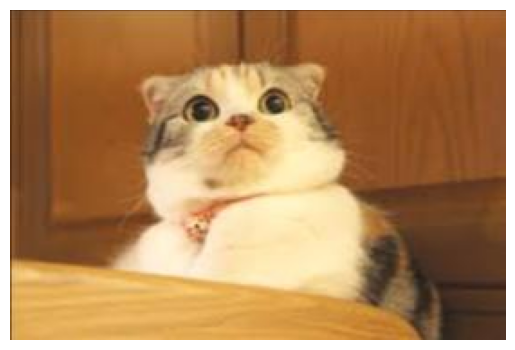

In [43]:

#test class with top3 predictions vs actual (pulled from the local dataset)
def test_random_image():
    model.eval()
    # Pick a random class folder
    class_idx = random.randint(0, num_classes-1)
    class_name = train_dataset.classes[class_idx]
    images_in_class = train_dataset.targets
    # Pick a random image path
    img_path = random.choice([train_dataset.imgs[i][0] for i in range(len(train_dataset)) if train_dataset.targets[i]==class_idx])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        top3_prob, top3_idx = torch.topk(probs, 3)

    print(f"Actual Mood: {class_name}")
    print("Top 3 Predictions:")
    for i in range(3):
        print(f"{train_dataset.classes[top3_idx[0][i]]}: {top3_prob[0][i]*100:.2f}%")

    # Show image
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.show()

# Call test function
test_random_image()
